# Comparison 2D

Comparison of algorithms provided in `localthickness` module with other algorithms. In particular, we compare with the conventional algorithm which uses dilation with discs of increasing radius (and is therefore painfully slow). This  serves as groundt truth. We also compare with the results of the algorithm from the [porespy](https://porespy.org/) package, [local_thickness](https://porespy.org/modules/generated/generated/porespy.filters.local_thickness.html). In 2D, we don't compare with [BoneJ](https://bonej.org/), as it requires 3D image.

This notebook is primarily intended to be **wieved** to check how our algorithms compare with other algorithms, in terms of run time and the quality of output. If you want to **run** the notebook, be aware that the conventional algorithm (which is here used as ground truth) takes a long time to run (204 sec), while `porespy` needs to be installed, and may require fixing a problem with `ipywidgets` as described bellow. 


In [1]:
import skimage.io
import matplotlib.pyplot as plt
import localthickness as lt
import porespy as ps
import time
import numpy as np


In [2]:
filename = 'data/test_2D_s.png'
B = skimage.io.imread(filename, as_gray = True) > 0.5  # Change to '<' to measure separation


In [3]:
# Conventional algorithm, this serves as ground truth.
print('Running conventional algorithm to serve as ground truth!')
print('This may take longish time to run if the image is larger than tiny!')
start_time = time.time()
thickness_gt = lt.local_thickness_conventional(B)
time_gt = time.time() - start_time


Running conventional algorithm to serve as ground truth!
This may take longish time to run if the image is larger than tiny!


In [4]:
# Our algorithms, without scaling.
start_time = time.time()
thickness_lt = lt.local_thickness(B)
time_lt = time.time() - start_time


In [5]:
# Our scaled algorithm. Scaling speeds up computation.
start_time = time.time()
thickness_scaled = lt.local_thickness_scaled(B, 0.3)
time_scaled = time.time() - start_time


Porespy uses `tqdm` which in notebook setting uses `ipwidgets`, and I had problems running it; The error was
```
cannot import name 'IProgress' from 'ipywidgets'
```
Running the next cell fixed the problem.

In [6]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [7]:
# Porespy algorithm. Using default settings.
start_time = time.time()
thickness_ps = ps.filters.local_thickness(B)  # possible to add sizes=30 (default 25)
time_ps = time.time() - start_time


  0%|          | 0/25 [00:00<?, ?it/s]

In [8]:
# Collecting histograms of local thickness from different algorithms.
maxval = thickness_gt.max()
b = np.linspace(0, np.ceil(maxval), 30)
c = 0.5*(b[1:]+b[:-1])
h_gt = np.histogram(thickness_gt[B], bins=b)[0]
h_lt = np.histogram(thickness_lt[B], bins=b)[0]
h_scaled = np.histogram(thickness_scaled[B], bins=b)[0]
h_ps = np.histogram(thickness_ps[B], bins=b)[0]


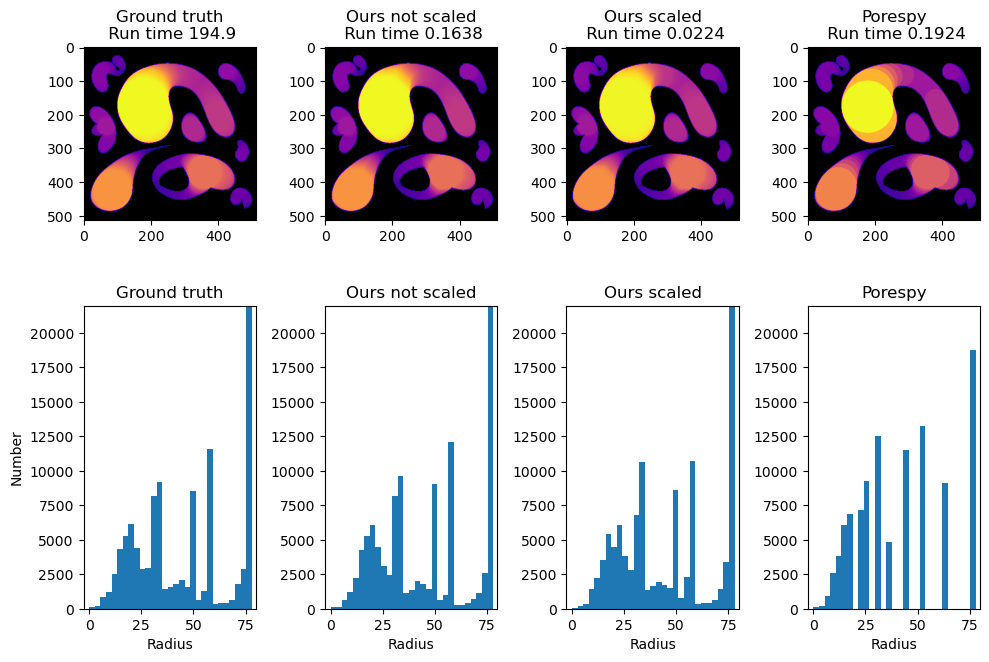

In [9]:
# Visualization.
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
ax[0][0].imshow(thickness_gt, vmin=0, vmax=maxval, cmap=lt.black_plasma())
ax[0][0].set_title(f'Ground truth\n Run time {time_gt:0.4}')
ax[0][1].imshow(thickness_lt, vmin=0, vmax=maxval, cmap=lt.black_plasma())
ax[0][1].set_title(f'Ours not scaled\n Run time {time_lt:0.4}')
ax[0][2].imshow(thickness_scaled, vmin=0, vmax=maxval, cmap=lt.black_plasma())
ax[0][2].set_title(f'Ours scaled\n Run time {time_scaled:0.4}')
ax[0][3].imshow(thickness_ps, vmin=0, vmax=maxval, cmap=lt.black_plasma())
ax[0][3].set_title(f'Porespy\n Run time {time_ps:0.4}')

ax[1][0].bar(c, h_gt, width=b[1])
ax[1][0].set_xlim([-b[1], maxval + b[1]])
ax[1][0].set_ylim([0, h_gt.max()])
ax[1][0].set_xlabel('Radius')
ax[1][0].set_ylabel('Number')
ax[1][0].set_title('Ground truth')

ax[1][1].bar(c, h_lt, width=b[1])
ax[1][1].set_xlim([-b[1], maxval + b[1]])
ax[1][1].set_ylim([0, h_gt.max()])
ax[1][1].set_xlabel('Radius')
#ax[1][1].set_ylabel('Number')
ax[1][1].set_title('Ours not scaled')

ax[1][2].bar(c, h_scaled, width=b[1])
ax[1][2].set_xlim([-b[1], maxval + b[1]])
ax[1][2].set_ylim([0, h_gt.max()])
ax[1][2].set_xlabel('Radius')
#ax[1][2].set_ylabel('Number')
ax[1][2].set_title('Ours scaled')

ax[1][3].bar(c, h_ps, width=b[1])
ax[1][3].set_xlim([-b[1], maxval + b[1]])
ax[1][3].set_ylim([0, h_gt.max()])
ax[1][3].set_xlabel('Radius')
#ax[1][3].set_ylabel('Number')
ax[1][3].set_title('Porespy')
plt.tight_layout()

plt.show()


###### Conclusion
In terms of quality (visually and by considering the histogram of values), our result without scalling is very similar to the conventional (ground truth) result. Using scaling influences the result only slightly. Result of porespy algorithm returns discrete values. Porespy does allow the user to decide how many values to consider (default is 25), so porespy result can be improved, but that would influence run time. 
In terms of run time, our algorithm without scaling is slightly faster than porespy. With scaling our algorithm is much faster. 

In [10]:
# Making cumulative sum of histograms for easier comparision
cs_gt = np.cumsum(h_gt)
cs_lt = np.cumsum(h_lt)
cs_scaled = np.cumsum(h_scaled)
cs_ps = np.cumsum(h_ps)

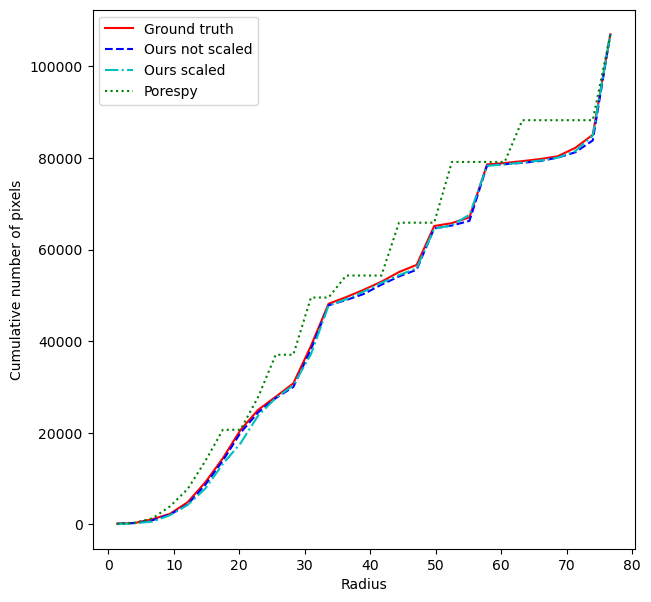

In [11]:
# Visualization.
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(c, cs_gt, 'r', c, cs_lt, 'b--', c, cs_scaled, 'c-.', c, cs_ps, 'g:')
ax.legend(['Ground truth', 'Ours not scaled', 'Ours scaled', 'Porespy']) 
ax.set_xlabel('Radius')
ax.set_ylabel('Cumulative number of pixels')
plt.show()

###### Conclusion
Our results are close to ground truth, especially without scalling. It seems that porespy underestimates local thickness, while we slightly overestimate.

In [12]:
# Computing difference in respect to ground truth.
d_lt = thickness_lt - thickness_gt
d_scaled = thickness_scaled - thickness_gt
d_ps = thickness_ps - thickness_gt
noise = np.random.random(size=B.sum()) - 0.5  # for a tinly bit of pertrubation


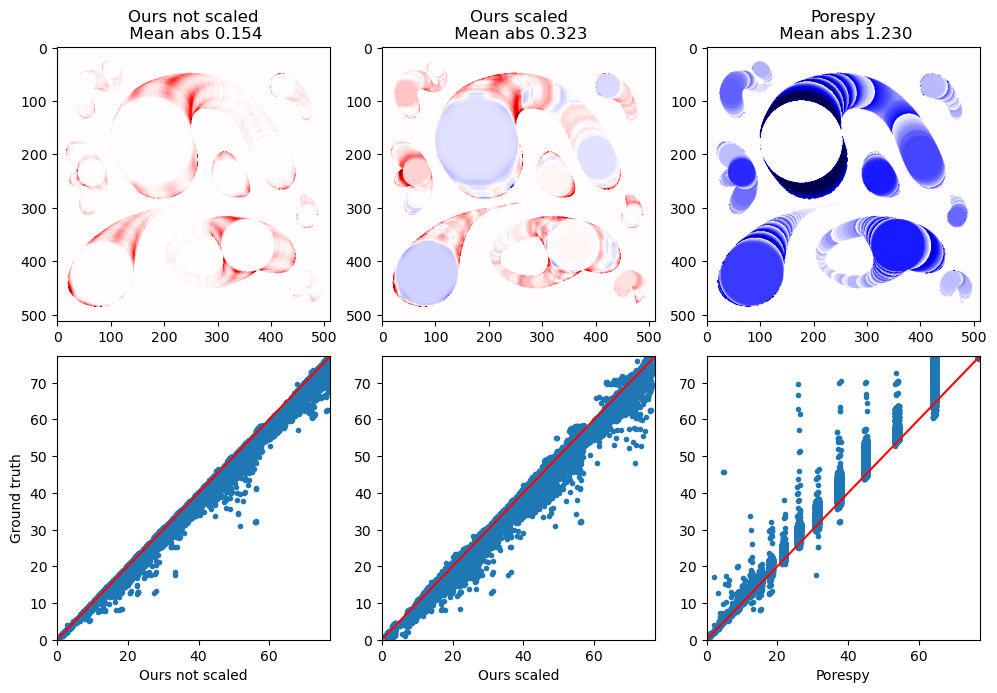

In [13]:
# Visualization.
val = 10  # colormap limits
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

ax[0][0].imshow(d_lt, vmin=-val, vmax=val, cmap=plt.cm.seismic)
ax[0][0].set_title(f'Ours not scaled\n Mean abs {abs(d_lt).mean():0.3f}')
ax[0][1].imshow(d_scaled, vmin=-val, vmax=val, cmap=plt.cm.seismic)
ax[0][1].set_title(f'Ours scaled\n Mean abs {abs(d_scaled).mean():0.3f}')
ax[0][2].imshow(d_ps, vmin=-val, vmax=val, cmap=plt.cm.seismic)
ax[0][2].set_title(f'Porespy\n Mean abs {abs(d_ps).mean():0.3f}')

ax[1][0].plot(thickness_lt[B] + noise, thickness_gt[B] + noise, '.')
ax[1][0].plot([0, maxval], [0, maxval], 'r')
ax[1][0].set_xlim([0, maxval])
ax[1][0].set_ylim([0, maxval])
ax[1][0].set_xlabel('Ours not scaled')
ax[1][0].set_ylabel('Ground truth')

ax[1][1].plot(thickness_scaled[B] + noise, thickness_gt[B] + noise, '.')
ax[1][1].plot([0, maxval], [0, maxval], 'r')
ax[1][1].set_xlim([0, maxval])
ax[1][1].set_ylim([0, maxval])
ax[1][1].set_xlabel('Ours scaled')
#ax[1][1].set_ylabel('Ground truth')

ax[1][2].plot(thickness_ps[B] + noise, thickness_gt[B] + noise, '.')
ax[1][2].plot([0, maxval], [0, maxval], 'r')
ax[1][2].set_xlim([0, maxval])
ax[1][2].set_ylim([0, maxval])
ax[1][2].set_xlabel('Porespy')
#ax[1][2].set_ylabel('Ground truth')
plt.tight_layout()
plt.show()


###### Conclusion
This confirms that we slightly overestimate local thickness, compared to ground truth. There are few areas where error is large with the difference of up to 50. Scaled algorithm has similar issues, but also places where it underestimates, especially in regions of large local thickness. Porespy generally underestimates, and only in few pixels overestimates. Results of porespy are discrete.